# Melanoma Detection Assignment

### Importing libraries

In [16]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os

import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob
from tensorflow.keras.preprocessing.image import load_img

### Mountig google drive

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Reading

In [18]:
# Defining the path for train and test images
df_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
df_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [19]:
image_count_train = len(list(df_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(df_test.glob('*/*.jpg')))
print(image_count_test)

2247
118


### Creating Train and Test Validation

In [20]:
#Using 80% of the images for training, and 20% for validation

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    df_train,
    image_size=(180, 180),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed = 123,
    label_mode='categorical'
)

print(train_data)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    df_train,
    image_size=(180, 180),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed = 123,
    label_mode='categorical'
)
print(validation_data)


Found 2247 files belonging to 9 classes.
Using 1798 files for training.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
Found 2247 files belonging to 9 classes.
Using 449 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


### Listing no. of images to their corrosponding class

In [ ]:
def class_count(directory):
      count= []
      for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
          count.append(len([name for name in os.listdir(path)
                    if os.path.isfile(os.path.join(path, name))]))

      sub_directory = [name for name in os.listdir(directory)
                        if os.path.isdir(os.path.join(directory, name))]

      return pd.DataFrame(list(zip(sub_directory,count)), columns =['Class','No. of Images'])

df = class_count(df_train)
df


,Class,No. of Images
0,melanoma,438
1,seborrheic keratosis,77
2,actinic keratosis,114
3,vascular lesion,139
4,dermatofibroma,95
5,basal cell carcinoma,376
6,squamous cell carcinoma,181
7,nevus,357
8,pigmented benign keratosis,470


#### From above table we can say
* Dermatofibroma has the least number of samples
* Keratosis has the most number of samples dominating the other classes

### Data Visualization

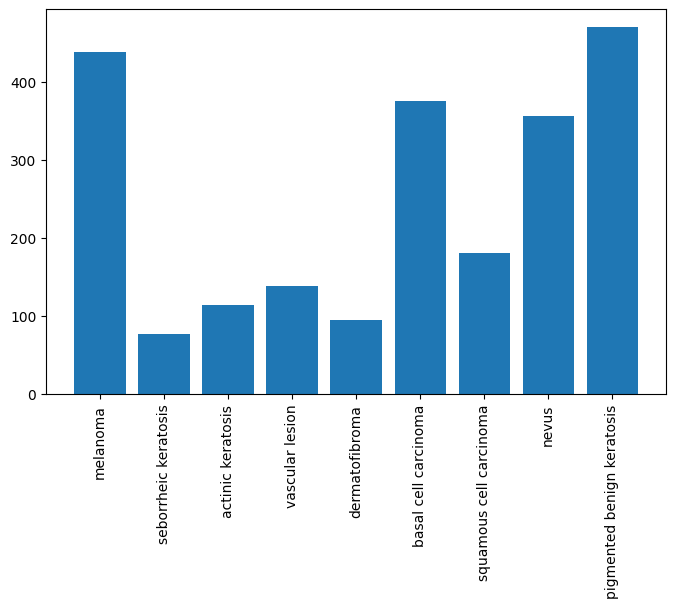

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(data =df, x='Class', height='No. of Images')
plt.xticks(rotation = 90)
plt.show()

### Creating Model

In [21]:
class_names = train_data.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
## Using autotune to ajusting the values
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = Sequential()

# Rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1. / 255))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer
model.add(layers.Dropout(0.5))

#Flatten layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer
model.add(layers.Dropout(0.25))

#Dense layer
model.add(layers.Dense(len(class_names),activation='softmax'))

model.build(input_shape=(32,180, 180, 3))



In [ ]:
#Compling model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 89, 89, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 43, 43, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 41, 41, 128)         7

### Training the model

In [ ]:
# taking 20 epochs
epochs = 20
history = model.fit(train_data, validation_data = validation_data, epochs=epochs )

Epoch 1/20
57/57 [==============================] - 153s 3s/step - loss: 2.0204 - accuracy: 0.2380 - val_loss: 1.9988 - val_accuracy: 0.2183
Epoch 2/20
57/57 [==============================] - 133s 2s/step - loss: 2.0164 - accuracy: 0.2425 - val_loss: 1.9625 - val_accuracy: 0.3363
Epoch 3/20
57/57 [==============================] - 134s 2s/step - loss: 1.9769 - accuracy: 0.2725 - val_loss: 2.0114 - val_accuracy: 0.1893
Epoch 4/20
57/57 [==============================] - 147s 3s/step - loss: 1.9337 - accuracy: 0.2992 - val_loss: 1.9303 - val_accuracy: 0.2249
Epoch 5/20
57/57 [==============================] - 136s 2s/step - loss: 1.9101 - accuracy: 0.2859 - val_loss: 1.9528 - val_accuracy: 0.2205
Epoch 6/20
57/57 [==============================] - 137s 2s/step - loss: 1.8690 - accuracy: 0.3098 - val_loss: 1.7426 - val_accuracy: 0.3808
Epoch 7/20
57/57 [==============================] - 135s 2s/step - loss: 1.8318 - accuracy: 0.3304 - val_loss: 2.1031 - val_accuracy: 0.2272
Epoch 8/20
57

#### As we can see train accuracy is 45% while val accuracy is 50% hence the model is underfit

### Visualizing training results

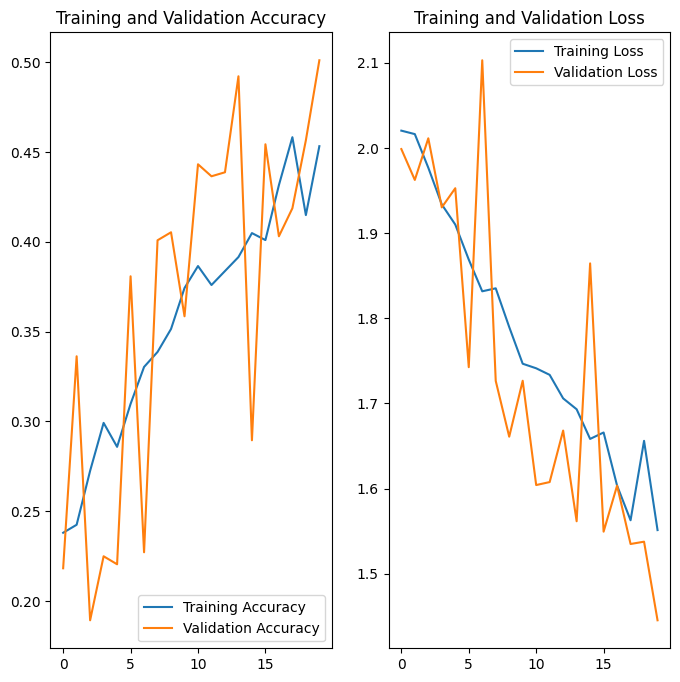

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Again Training the model with batch normalization after every conv. layer and dropout

In [ ]:
#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


# Flatten layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

model.build(input_shape=(32,180, 180, 3))


In [ ]:
# compiling model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 178, 178, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (32, 178, 178, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (32, 176, 176, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (32, 176, 176, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 88, 88, 32)         

In [ ]:
# Taking 20 epochs
epochs = 20
history = model.fit(train_data, validation_data = validation_data, epochs=epochs )

Epoch 1/20
57/57 [==============================] - 490s 8s/step - loss: 4.3403 - accuracy: 0.2608 - val_loss: 2.1400 - val_accuracy: 0.1960
Epoch 2/20
57/57 [==============================] - 458s 8s/step - loss: 2.0163 - accuracy: 0.3315 - val_loss: 5.5014 - val_accuracy: 0.1269
Epoch 3/20
57/57 [==============================] - 468s 8s/step - loss: 1.9410 - accuracy: 0.3365 - val_loss: 3.4593 - val_accuracy: 0.2004
Epoch 4/20
57/57 [==============================] - 462s 8s/step - loss: 1.7748 - accuracy: 0.3921 - val_loss: 7.9249 - val_accuracy: 0.1893
Epoch 5/20
57/57 [==============================] - 459s 8s/step - loss: 1.7131 - accuracy: 0.4199 - val_loss: 3.5090 - val_accuracy: 0.1737
Epoch 6/20
57/57 [==============================] - 451s 8s/step - loss: 1.6480 - accuracy: 0.4238 - val_loss: 4.1598 - val_accuracy: 0.2094
Epoch 7/20
57/57 [==============================] - 460s 8s/step - loss: 1.6441 - accuracy: 0.4205 - val_loss: 2.7743 - val_accuracy: 0.2717
Epoch 8/20
57

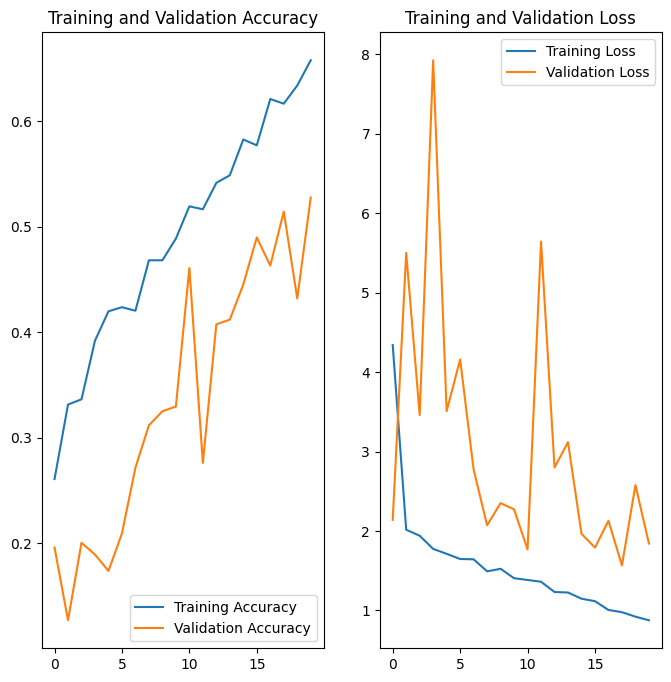

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As through visualization its clearly seen trained and predicted data has huge difference

### Adding more samples through Augmentor 

In [24]:
# creating pipeline

path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
total_samples = 0
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    num_augmented_samples = 500
    p.sample(num_augmented_samples)


    total_samples += num_augmented_samples

Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEBA41FC9D0>: 100%|██████████| 500/500 [00:52<00:00,  9.58 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEBA410B070>: 100%|██████████| 500/500 [00:41<00:00, 11.99 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEB97F1EC20>: 100%|██████████| 500/500 [00:38<00:00, 12.84 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEBA42879D0>: 100%|██████████| 500/500 [00:40<00:00, 12.46 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEBA419F4C0>: 100%|██████████| 500/500 [00:43<00:00, 11.43 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEBA4175060>: 100%|██████████| 500/500 [00:38<00:00, 12.85 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEC36225480>: 100%|██████████| 500/500 [00:43<00:00, 11.51 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEB97F3BA60>: 100%|██████████| 500/500 [00:36<00:00, 13.62 Samples/s]


Initialised with 2247 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FEBA41BF130>: 100%|██████████| 500/500 [00:46<00:00, 10.78 Samples/s]


In [25]:
total_samples

4500

In [26]:
train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")

In [50]:
##  Using 80% data for training and 20% for validation
train_data = tf.keras.preprocessing.image_dataset_from_directory(train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [51]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="validation",
                                                               validation_split=0.2)


Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer

model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#dropout layer
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.build(input_shape=(32,180, 180, 3))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

In [43]:
epochs = 30
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

Epoch 1/30
113/113 [==============================] - 30s 96ms/step - loss: 2.0433 - accuracy: 0.2000 - val_loss: 2.0175 - val_accuracy: 0.2033
Epoch 2/30
113/113 [==============================] - 6s 49ms/step - loss: 2.0099 - accuracy: 0.2169 - val_loss: 1.9840 - val_accuracy: 0.2522
Epoch 3/30
113/113 [==============================] - 7s 59ms/step - loss: 1.9676 - accuracy: 0.2622 - val_loss: 1.9200 - val_accuracy: 0.2889
Epoch 4/30
113/113 [==============================] - 6s 50ms/step - loss: 1.9090 - accuracy: 0.2953 - val_loss: 1.8446 - val_accuracy: 0.3311
Epoch 5/30
113/113 [==============================] - 6s 52ms/step - loss: 1.8495 - accuracy: 0.3211 - val_loss: 1.7567 - val_accuracy: 0.3656
Epoch 6/30
113/113 [==============================] - 6s 55ms/step - loss: 1.8056 - accuracy: 0.3492 - val_loss: 1.6857 - val_accuracy: 0.4078
Epoch 7/30
113/113 [==============================] - 6s 50ms/step - loss: 1.7907 - accuracy: 0.3472 - val_loss: 1.9057 - val_accuracy: 0.292

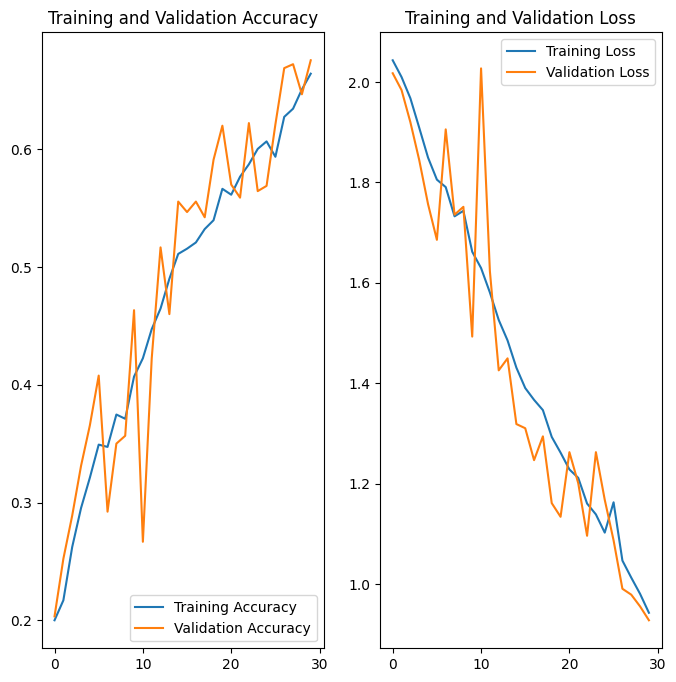

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 33ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


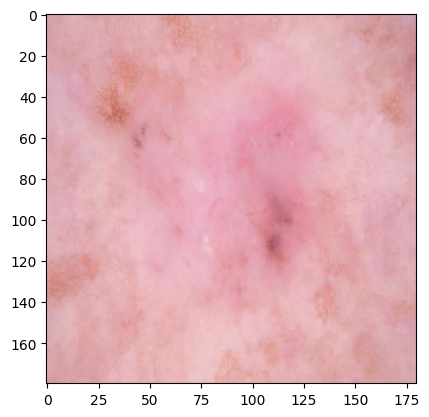

In [49]:

Test_image_path = os.path.join(df_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

In [53]:
model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


# Flatten layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

model.build(input_shape=(32,180, 180, 3))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 176, 176, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 88, 88, 32)       

In [54]:
epochs = 30
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

Epoch 1/30
113/113 [==============================] - 48s 213ms/step - loss: 1.9305 - accuracy: 0.4067 - val_loss: 5.3722 - val_accuracy: 0.1644
Epoch 2/30
113/113 [==============================] - 16s 142ms/step - loss: 1.3956 - accuracy: 0.5044 - val_loss: 5.2080 - val_accuracy: 0.1644
Epoch 3/30
113/113 [==============================] - 16s 143ms/step - loss: 1.2137 - accuracy: 0.5756 - val_loss: 3.3804 - val_accuracy: 0.2689
Epoch 4/30
113/113 [==============================] - 16s 145ms/step - loss: 1.0898 - accuracy: 0.6111 - val_loss: 1.7868 - val_accuracy: 0.4644
Epoch 5/30
113/113 [==============================] - 16s 144ms/step - loss: 0.9615 - accuracy: 0.6514 - val_loss: 1.8605 - val_accuracy: 0.5156
Epoch 6/30
113/113 [==============================] - 16s 143ms/step - loss: 0.8243 - accuracy: 0.6986 - val_loss: 2.1542 - val_accuracy: 0.4533
Epoch 7/30
113/113 [==============================] - 16s 142ms/step - loss: 0.7256 - accuracy: 0.7289 - val_loss: 1.0910 - val_ac

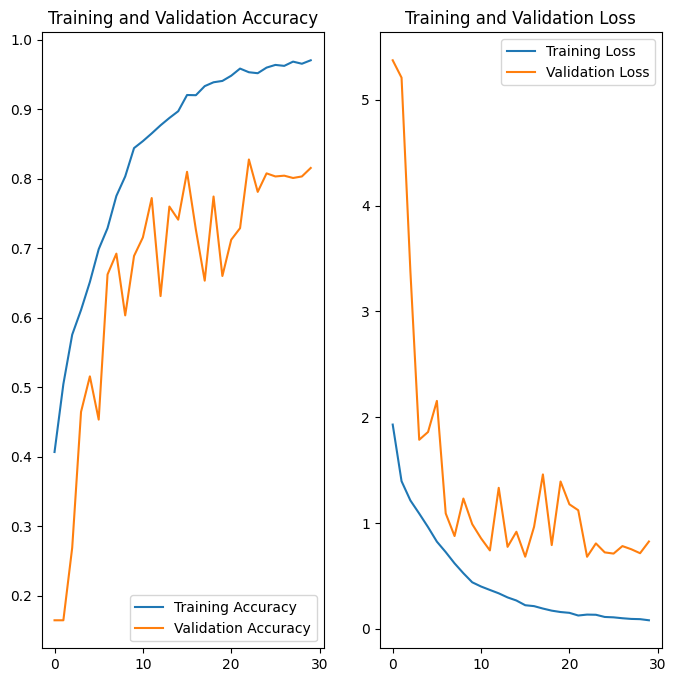

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion 
* Augmented data with dropout at the end of conv layer and flatten layer and sgd optimizer giving a better result than others